In [1]:
%load_ext autoreload
%autoreload 2

# Analysis of sequence-level mutations

For DPhil thesis.

In [2]:
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from functools import partial

from synbio_morpher.utils.results.analytics.naming import get_true_interaction_cols
from synbio_morpher.utils.results.analytics.timeseries import calculate_adaptation
from common import set_theme, add_sample_names

set_theme(style='whitegrid')
PALETTE = 'viridis'

top_write_dir = os.path.join('data', '25_mutations')

# Load data

When loading the data, we have to make sure to use the up-to-date versions of all the datasets. Dataset `2024_11_27_145142` was resimulated with different starting copy numbers in the following: 

Datasets:
- Original: `2024_11_27_145142`
- Starting copies = 100, dt0 = 0.0001: `2026_01_12__18_50_13`
- Starting copies = 200, dt0 = 0.0001: `2026_01_14__22_38_47`
- Starting copies = 100, dt0 = 0.01: `2026_01_15__15_43_12`

Meanwhile, dataset `2024_11_21_160955` was resimulated as dataset `2025_02_11__13_56_51`. 

In [3]:
# fn = '../data/raw/summarise_simulation/2024_11_27_145142/tabulated_mutation_info.csv'
# # fn = '../data/raw/summarise_simulation/2024_11_21_160955/tabulated_mutation_info.csv'
# # fn = 'data/simulate_circuits/2025_02_11__13_56_51/tabulated_mutation_info.json'
# fn_resim = 'data/simulate_circuits/2026_01_15__15_43_12/analytics.json'
# data = pd.read_csv(fn)
# df_resim = pd.read_json(fn_resim).drop(columns=['RMSE'])
# df_resim = df_resim.explode(df_resim.columns.to_list()).reset_index(drop=True)
# cols_analytics = df_resim.columns
# data[cols_analytics] = df_resim[cols_analytics].values
# del df_resim


fn_og = '../data/raw/summarise_simulation/2024_11_27_145142/tabulated_mutation_info.csv'
# fn_resim = 'data/simulate_circuits/2026_01_15__15_43_12/analytics.json'
fn_resim = 'data/simulate_circuits/2026_01_12__18_50_13/analytics.json'
data = pd.read_csv(fn_og)
df_resim = pd.read_json(fn_resim).drop(columns='RMSE')
df_resim = df_resim.explode(df_resim.columns.to_list()).reset_index(drop=True)
cols_resim = list(df_resim.columns)

In [4]:
names_species_input = data['sample_name'].unique()
n_species_input = len(names_species_input)
n_species_total = int(len(df_resim) / len(data) * n_species_input)

df_resim = add_sample_names(df_resim, names_species_input, n_species_input, n_species_total)
data[cols_resim] = df_resim.query('sample_name in ["RNA_0", "RNA_1", "RNA_2"]')[cols_resim].values.astype(np.float32)
del df_resim

In [5]:
data.rename(columns={'mutation_num': 'N mutations'}, inplace=True)
data['Log sensitivity'] = np.log10(data['sensitivity'])
data['Log precision'] = np.log10(data['precision'])
data['adaptation'] = calculate_adaptation(np.array(data['sensitivity']), np.array(data['precision']), alpha=2)


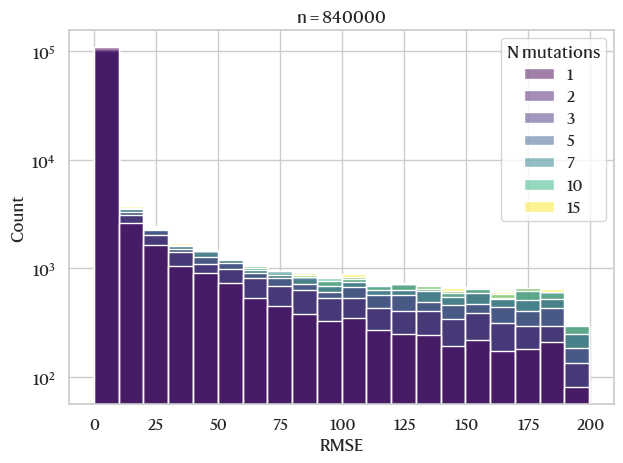

In [6]:
filt_samp = (data['sample_name'] == 'RNA_2')
filt_m = (data['N mutations'] > 0)
filt = filt_m & filt_samp & (
    data['RMSE'].notnull()) & (data['RMSE'] < np.inf)
g = sns.histplot(data[filt], x='RMSE', hue='N mutations',
             palette=PALETTE,
             bins=20) #, fill=False, element='step')
plt.yscale('log')
plt.title(f'n = {len(data[filt])}')
plt.tight_layout()
plt.savefig(os.path.join(top_write_dir, 'mutation_rmse_histogram.png'), dpi=300, transparent=True)

In [7]:
get_true_interaction_cols2 = partial(
    get_true_interaction_cols, remove_symmetrical=True, num_species=data['sample_name'].nunique())

datam = pd.DataFrame()
k = 'energies'
cols_e = get_true_interaction_cols2(data, k)
datam[f'{k}_diffs'] = data[filt_samp].groupby(['circuit_name'])[cols_e].apply(
    lambda x: x - x.iloc[0]).melt(value_vars=cols_e,
                                  var_name='idx', value_name=f'{k}_diffs')[f'{k}_diffs']
data['is_null'] = data[cols_e].sum(axis=1) == 0
data['is_null_ref'] = data['is_null'] & data['circuit_name'].isin(
    data[(data['N mutations'] == 0) & data['is_null']]['circuit_name'].unique())
cols_to_keep = ['circuit_name', 'is_null', 'N mutations']
datam[cols_to_keep + ['idx']] = data[filt_samp].melt(
    id_vars=cols_to_keep, value_vars=cols_e,
    var_name='idx', value_name=f'{k}_diffs')[cols_to_keep + ['idx']]
datam['stayed_null'] = datam['is_null'] & data['is_null_ref'] & (datam[f'{k}_diffs'] == 0)

In [8]:
for k in ['Log sensitivity', 'Log precision', 'adaptation']:
    # data[f'{k} diffs'] = data.groupby(['circuit_name', 'sample_name'])[k].apply(lambda x: x - x.iloc[0]).reset_index()[k]
    data[f'{k} diffs'] = data.groupby(['circuit_name', 'sample_name'])[k].apply(lambda x: x - x.iloc[0]).reset_index().sort_values('level_2').reset_index()[k]

n = 5000 reference circuits


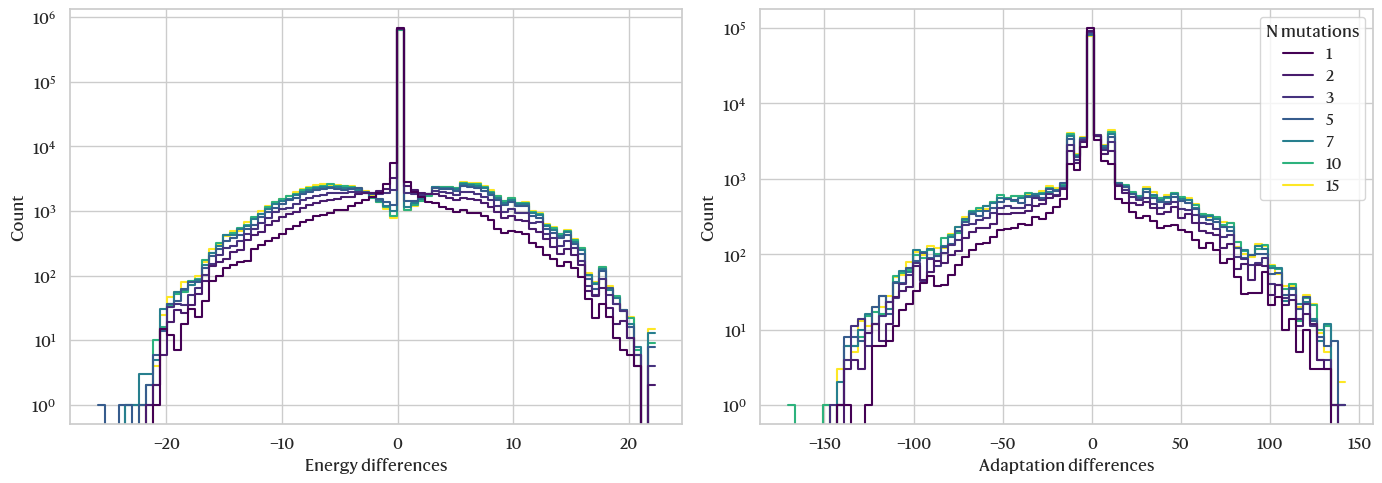

In [9]:
# plt.figure(figsize=(7,5))
fig, axs = plt.subplots(1, 2, figsize=(14, 5))
sns.histplot(datam[datam['N mutations'] > 0], x=f'energies_diffs', hue='N mutations',
             palette=PALETTE, bins=80, fill=False, element='step', ax=axs[0], legend=False)
axs[0].set_xlabel('Energy differences')
axs[0].set_yscale('log')

g = sns.histplot(data[filt_m & filt_samp], x=f'adaptation diffs', hue='N mutations',
                 # sns.histplot(data[filt_m & filt_samp], x=f'Log sensitivity diffs', hue='N mutations',
                 palette=PALETTE, bins=80, fill=False, element='step', ax=axs[1])
sns.move_legend(axs[1], "upper right",
                bbox_to_anchor=(1, 1), title='N mutations')
axs[1].set_xlabel('Adaptation differences')
axs[1].set_yscale('log')

plt.tight_layout()
plt.savefig(os.path.join(top_write_dir, 'mutation_energy_adaptation_diffs_histogram.png'),
            dpi=300, transparent=True, bbox_inches='tight')

print(f'n = {data["circuit_name"].nunique()} reference circuits')

840000


adaptation
836.823364    369235
836.826294       766
836.990173       609
836.825439       535
836.828369       516
               ...  
840.877991         1
836.904785         1
837.629944         1
802.798218         1
743.812500         1
Name: count, Length: 117892, dtype: int64

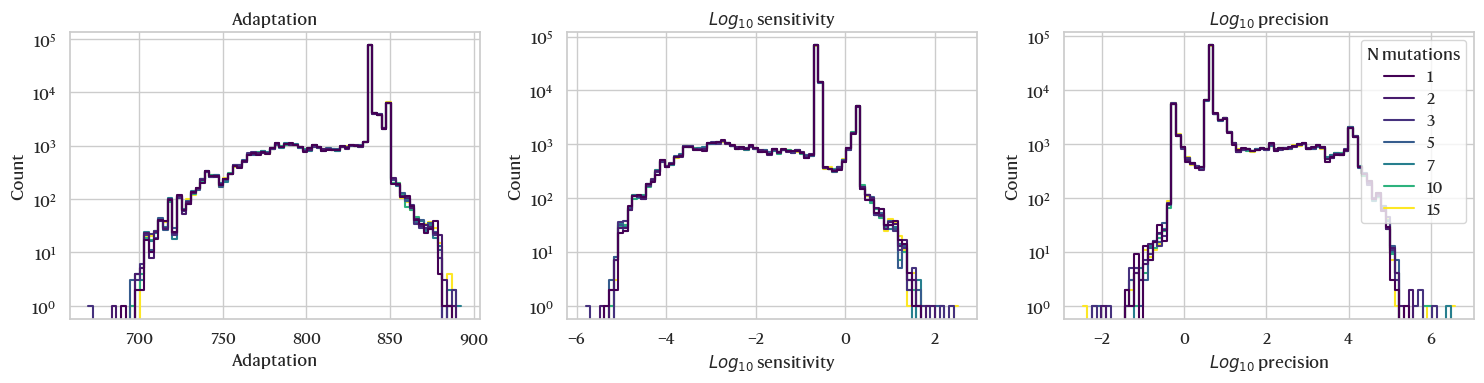

In [10]:
fig, axs = plt.subplots(1, 3, figsize=(5 * 3, 4))
for i, col in enumerate(['adaptation', 'Log sensitivity', 'Log precision']):
    g = sns.histplot(data[filt_m & filt_samp], x=col, hue='N mutations',
                    palette=PALETTE, bins=80, fill=False, element='step', ax=axs[i],
                    legend=(i==2))
    if i == 2:
        sns.move_legend(axs[i], "upper right", bbox_to_anchor=(1, 1), title='N mutations')
    axs[i].set_xlabel(col.capitalize().replace('Log', f'$Log_{{10}}$'))
    axs[i].set_yscale('log')
    axs[i].set_title(col.capitalize().replace('Log', f'$Log_{{10}}$'))
plt.tight_layout()
plt.savefig(os.path.join(top_write_dir, 'mutation_adaptation_comparison_nodiffs.png'),
            dpi=300, transparent=True, bbox_inches='tight')

print(len(data[filt_m & filt_samp]))
data[filt_m & filt_samp]['adaptation'].value_counts()

Energy differences may be different for self-interactions vs. cross-interactions

In [11]:
# for k in cols_e:
#     data[k + '_diffs'] = data.groupby(['circuit_name', 'sample_name'])[k].apply(
#         lambda x: x - x.iloc[0]).reset_index().set_index('level_2').sort_index()[k]
# data.iloc[:1000].groupby(['circuit_name', 'sample_name'])[k].apply(
#     lambda x: x - x.iloc[0]).reset_index().set_index('level_2').sort_index()[k]
# data.drop(columns=[k + '_diffs' for k in cols_e], inplace=True, errors='ignore')

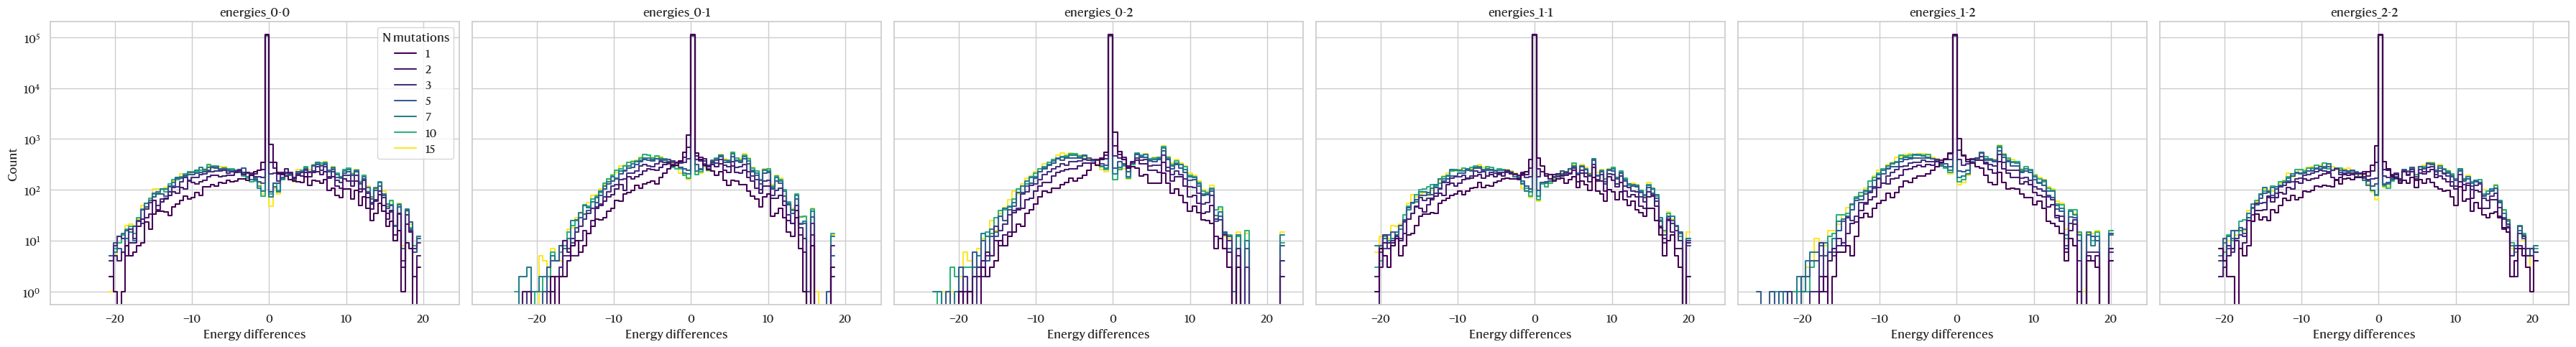

In [28]:
n_cols = len(cols_e)
fig, axs = plt.subplots(1, n_cols, figsize=(6 * n_cols, 5), sharey=True, sharex=True)

for i, k in enumerate(cols_e):
    filt = (datam['idx'] == k) & (datam['N mutations'] > 0)
    sns.histplot(datam[filt], x=f'energies_diffs', hue='N mutations',
                palette=PALETTE, bins=80, fill=False, element='step', ax=axs[i], legend=i == 0)
    axs[i].set_xlabel('Energy differences')
    axs[i].set_yscale('log')
    axs[i].set_title(k)
    
plt.tight_layout()
plt.savefig(os.path.join(top_write_dir, 'mutation_energy_diffs_individual.png'),
            dpi=300, transparent=True, bbox_inches='tight')

In [13]:
cols_e_self = [k for k in cols_e if k.split('_')[1].split('-')[0] == k.split('_')[1].split('-')[1]]
cols_e_diff = [k for k in cols_e if k not in cols_e_self]

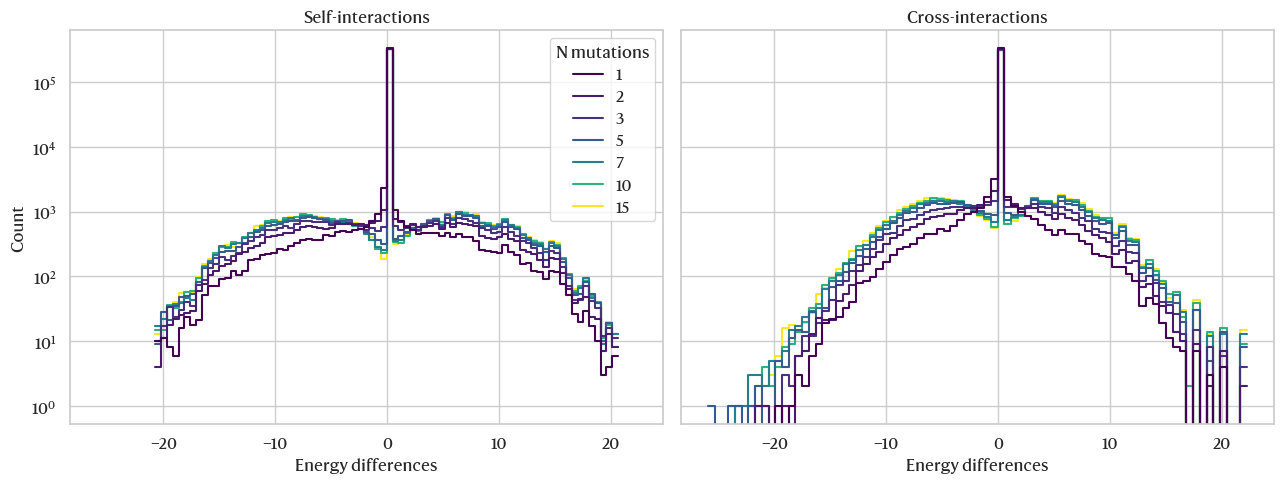

In [14]:
fig, axs = plt.subplots(1, 2, figsize=(13, 5), sharex=True, sharey=True)
filt_same = datam['idx'].isin(cols_e_self) & (datam['N mutations'] > 0)
sns.histplot(datam[filt_same], x=f'energies_diffs', hue='N mutations',
             palette=PALETTE, bins=80, fill=False, element='step', ax=axs[0], legend=True)
axs[0].set_xlabel('Energy differences')
axs[0].set_yscale('log')
axs[0].set_title('Self-interactions')

filt_diff = datam['idx'].isin(cols_e_diff) & (datam['N mutations'] > 0)
sns.histplot(datam[filt_diff], x=f'energies_diffs', hue='N mutations',
             palette=PALETTE, bins=80, fill=False, element='step', ax=axs[1], legend=False)
axs[1].set_xlabel('Energy differences')
axs[1].set_yscale('log')
axs[1].set_title('Cross-interactions')

plt.tight_layout()
plt.savefig(os.path.join(top_write_dir, 'mutation_energy_diffs_self_cross.png'),
            dpi=300, transparent=True, bbox_inches='tight')

### Distribution of changes for non-null circuits

n = 5000 reference circuits
Number of circuits energy diffs 780400.1666666666
Number of circuits adaptation diffs 555652


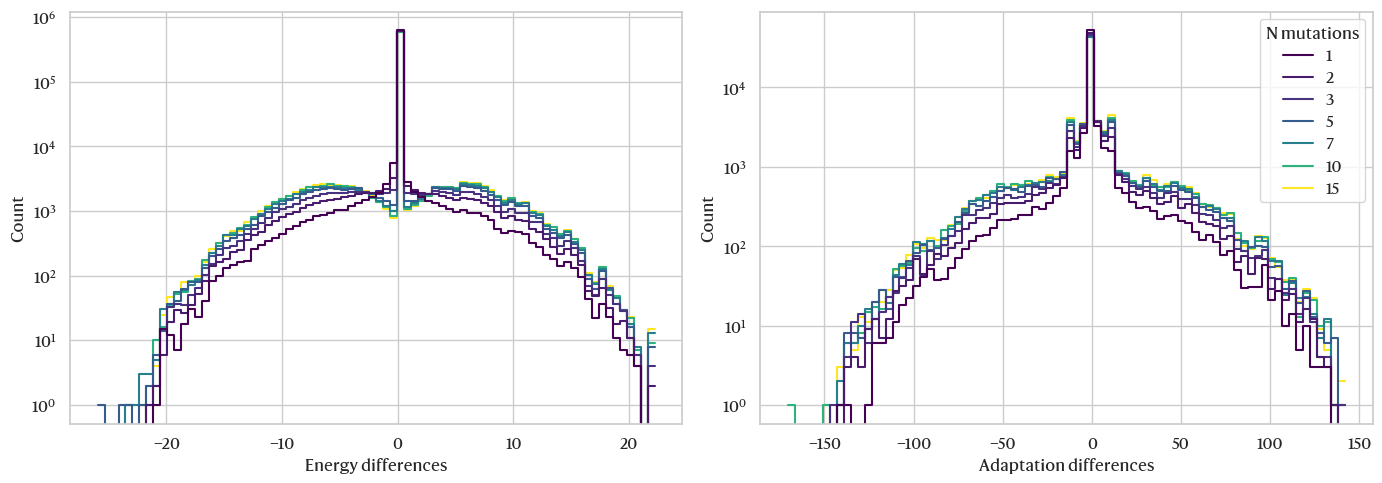

In [15]:
# plt.figure(figsize=(7,5))
filt_no_null = ~datam['stayed_null']

fig, axs = plt.subplots(1, 2, figsize=(14, 5))
sns.histplot(datam[filt_no_null & (datam['N mutations'] > 0)], 
             x=f'energies_diffs', hue='N mutations',
             palette=PALETTE, bins=80, fill=False, element='step', ax=axs[0], legend=False)
axs[0].set_xlabel('Energy differences')
axs[0].set_yscale('log')

g = sns.histplot(data[filt_m & filt_samp & ~data['is_null_ref']], 
                 x=f'adaptation diffs', hue='N mutations',
                 # sns.histplot(data[filt_m & filt_samp], x=f'Log sensitivity diffs', hue='N mutations',
                 palette=PALETTE, bins=80, fill=False, element='step', ax=axs[1])
sns.move_legend(axs[1], "upper right",
                bbox_to_anchor=(1, 1), title='N mutations')
axs[1].set_xlabel('Adaptation differences')
axs[1].set_yscale('log')

plt.tight_layout()
plt.savefig(os.path.join(top_write_dir, 'mutation_energy_adaptation_diffs_nonull.png'),
            dpi=300, transparent=True, bbox_inches='tight')

print(f'n = {data["circuit_name"].nunique()} reference circuits')
print('Number of circuits energy diffs', len(datam[filt_no_null & (datam['N mutations'] > 0)]) / len(cols_e))
print('Number of circuits adaptation diffs', len(data[filt_m & filt_samp & ~data['is_null_ref']]))

<Axes: xlabel='energies_diffs', ylabel='Count'>

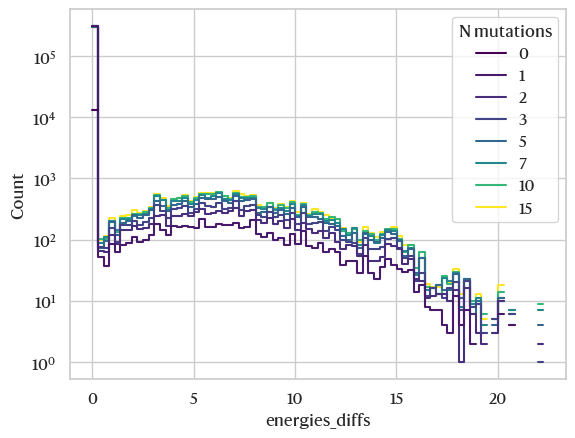

In [16]:
sns.histplot(datam[datam['is_null']], 
             x=f'energies_diffs', hue='N mutations',
             palette=PALETTE, bins=80, fill=False, element='step',
             log_scale=[False, True])

# Mutation type and position

In [17]:
import ast

data['mutation_type_list'] = data['mutation_type'].apply(ast.literal_eval)
data['mutation_positions_list'] = data['mutation_positions'].apply(ast.literal_eval)


In [18]:
cols = ['mutation_type_list', 'mutation_positions_list', 'N mutations', 'circuit_name', 'mutation_name',
        'adaptation diffs', 'Log sensitivity diffs', 'Log precision diffs', 
        'adaptation', 'sensitivity', 'precision', 'Log sensitivity', 'Log precision']
df_mutations = data[filt_samp][cols].explode('mutation_type_list').reset_index()
df_mutations['mutation_positions_list'] = data[filt_samp & filt_m][cols].explode('mutation_positions_list').reset_index()['mutation_positions_list']

In [19]:
from synbio_morpher.utils.evolution.mutation import get_mutation_type_mapping


def reverse_mut_mapping_custom(mut_encoding: int, sequence_type: str = 'RNA'):
    for k, v in get_mutation_type_mapping(sequence_type).items():
        if mut_encoding in list(v.values()):
            for mut, enc in v.items():
                if enc == mut_encoding:
                    return f'{k}->{mut}'
    raise ValueError(
        f'Could not find mutation for mapping key {mut_encoding}.')
    
    
mut_flatmap = {i: reverse_mut_mapping_custom(i, 'RNA')
               for i in sorted(df_mutations['mutation_type_list'].unique()) if np.isnan(i) == False}

df_mutations['Mutation Type'] = df_mutations['mutation_type_list'].apply(
    lambda x: mut_flatmap[x] if np.isnan(x) == False else 'NA')


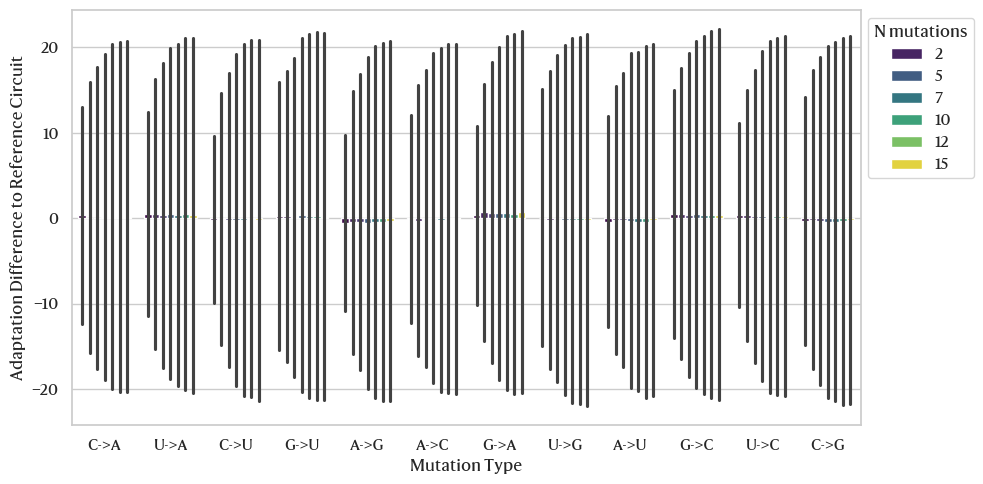

In [20]:
plt.figure(figsize=(10, 5))
g = sns.barplot(df_mutations[df_mutations['N mutations'] > 0],
                x='Mutation Type', y='adaptation diffs',
                hue='N mutations',
                palette=PALETTE, errorbar='sd')
sns.move_legend(g, "upper left", bbox_to_anchor=(1, 1))
plt.ylabel('Adaptation Difference to Reference Circuit')
# plt.xlabel('Mutation Type')
plt.tight_layout()
plt.savefig(os.path.join(top_write_dir, 'mutation_type_adaptation_diffs.png'),
            dpi=300, bbox_inches='tight', transparent=True)

# Mutation position

In [21]:
df_mutations[(df_mutations['N mutations'] == 0) & (df_mutations['Log sensitivity'] > 0)]

,index,mutation_type_list,mutation_positions_list,N mutations,circuit_name,mutation_name,adaptation diffs,Log sensitivity diffs,Log precision diffs,adaptation,sensitivity,precision,Log sensitivity,Log precision,Mutation Type
56815,27887,NaN,6,0,toy_mRNA_circuit_1047,ref_circuit,0.0,0.0,0.0,849.574585,1.345882,1.038475,0.129007,0.016396,NA
57848,28394,NaN,18,0,toy_mRNA_circuit_1048,ref_circuit,0.0,0.0,0.0,848.320251,1.613111,0.619920,0.207664,-0.207664,NA
68178,33464,NaN,18,0,toy_mRNA_circuit_1057,ref_circuit,0.0,0.0,0.0,849.366333,1.989679,0.502594,0.298783,-0.298783,NA
87805,43097,NaN,14,0,toy_mRNA_circuit_1074,ref_circuit,0.0,0.0,0.0,849.334045,1.976521,0.505940,0.295901,-0.295901,NA
99168,48674,NaN,19,0,toy_mRNA_circuit_1084,ref_circuit,0.0,0.0,0.0,849.058838,1.868713,0.535128,0.271543,-0.271543,NA
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5132977,2519285,NaN,19,0,toy_mRNA_circuit_971,ref_circuit,0.0,0.0,0.0,849.315796,1.969148,0.507834,0.294278,-0.294278,NA
5148472,2526890,NaN,6,0,toy_mRNA_circuit_985,ref_circuit,0.0,0.0,0.0,847.776978,1.452039,0.688687,0.161978,-0.161978,NA
5152604,2528918,NaN,16,0,toy_mRNA_circuit_989,ref_circuit,0.0,0.0,0.0,848.622620,1.712212,0.584040,0.233558,-0.233558,NA
5156736,2530946,NaN,0,0,toy_mRNA_circuit_992,ref_circuit,0.0,0.0,0.0,847.174988,1.295802,0.771723,0.112538,-0.112538,NA


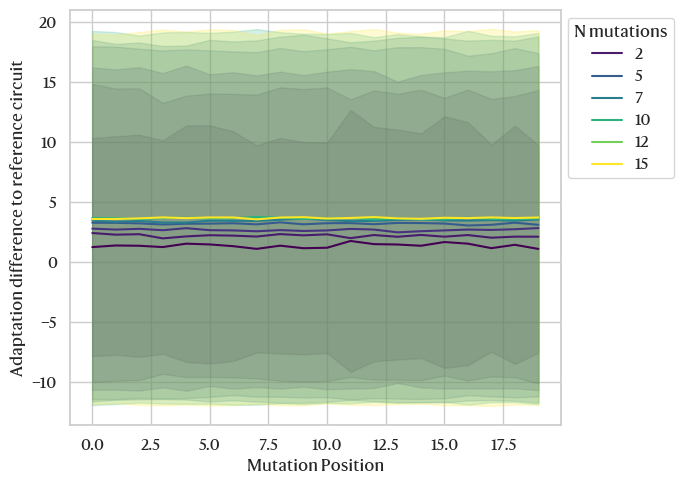

In [22]:
plt.figure(figsize=(7, 5))
g = sns.lineplot(df_mutations[(df_mutations['Log sensitivity'] >= -1) & (df_mutations['Log precision'] >= 0)
                              & (df_mutations['N mutations'] > 0)],
                 x='mutation_positions_list', y='adaptation diffs',
                 hue='N mutations',
                 palette=PALETTE, errorbar='sd')
sns.move_legend(g, "upper left", bbox_to_anchor=(1, 1))
plt.xlabel('Mutation Position')
plt.ylabel('Adaptation difference to reference circuit')
plt.tight_layout()
plt.savefig(os.path.join(top_write_dir, 'mutation_position_adaptation_diffs.png'),
            dpi=300, bbox_inches='tight', transparent=True)

# Plot the adaptation by circuit index, with the number of mutations as the hue

This was not super informative

In [23]:
# # data['circuit_idx'] = 
# data['circuit_idx'] = 0
# for s in data['sample_name'].unique():
#     d = dict(data[(data['N mutations'] == 0) & (data['sample_name'] == s)].sort_values('adaptation').reset_index(
#         ).rename(columns={'level_0': 'idx'}).reset_index()[['circuit_name', 'level_0']].values.tolist()) #.reset_index().groupby('circuit_name').ngroup()
#     data.loc[data['sample_name'] == s, 'circuit_idx'] = data[data['sample_name'] == s]['circuit_name'].apply(lambda x: d[x])

In [24]:
# sns.scatterplot(data[(data['sample_name'] == 'RNA_2') & (data['N mutations'] < 3)].sort_values('N mutations', ascending=False),
#                 x='circuit_idx', y='adaptation', hue='N mutations', palette=PALETTE, alpha=0.1)
# sns.scatterplot(data[(data['sample_name'] == 'RNA_2') & (data['N mutations'] == 0)].sort_values('N mutations', ascending=False),
#                 x='circuit_idx', y='adaptation', hue='N mutations', palette=PALETTE)

In [25]:
# df_transitions = data[filt_samp].melt(id_vars=['circuit_name', 'mutation_name', 'N mutations'],
#                                       value_vars=['Log sensitivity',
#                                                   'Log precision', 'adaptation'],
#                                       var_name='Metric', value_name='Value')

for k in ['adaptation', 'Log sensitivity', 'Log precision']:
    data['Original ' + k] = data.groupby(['circuit_name', 'sample_name'])[k].apply(
        lambda x: x.iloc[0] * np.ones(len(x))).explode().reset_index()[k]

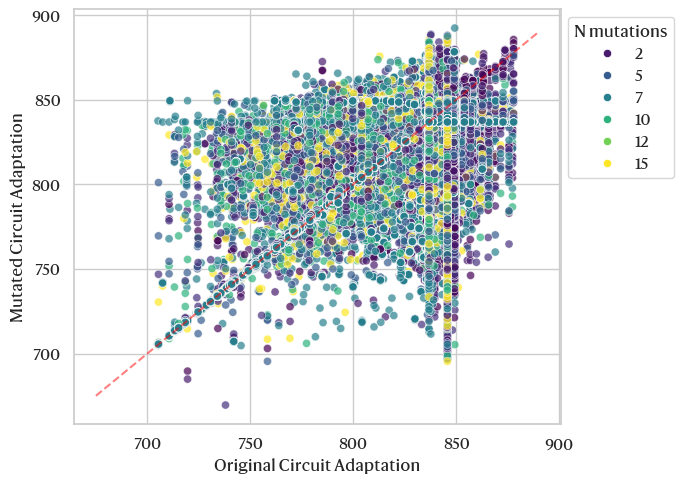

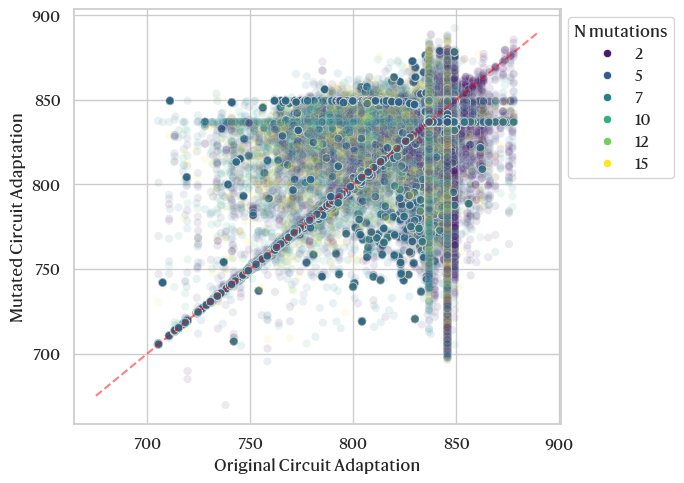

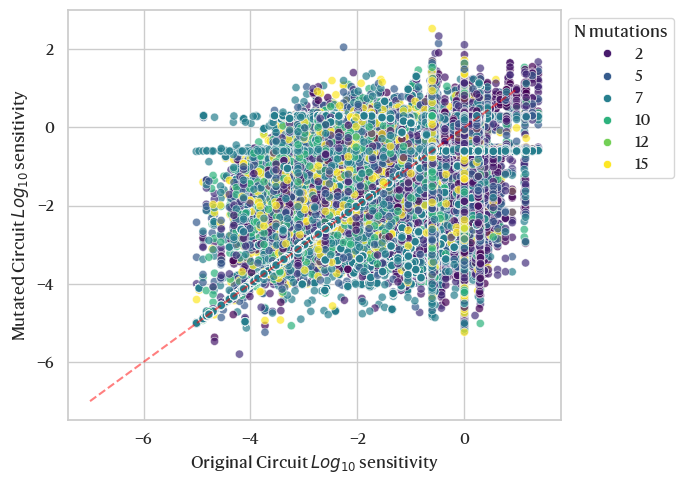

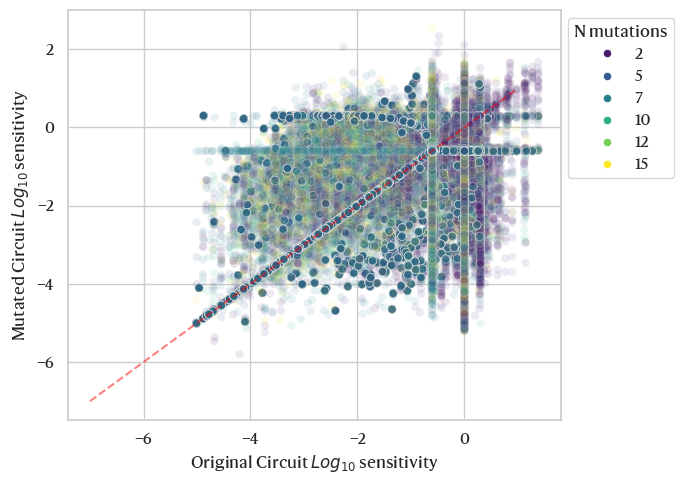

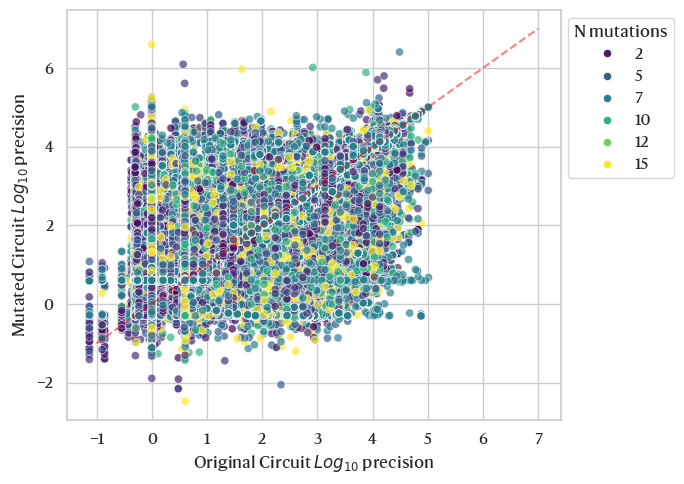

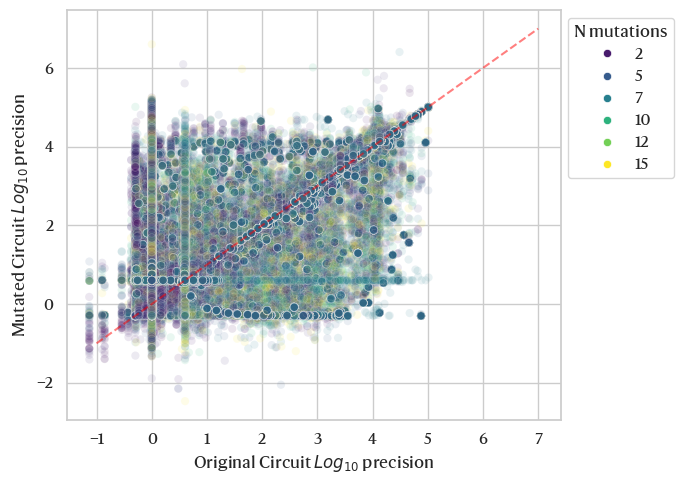

In [26]:
for k, xlim in zip(['adaptation', 'Log sensitivity', 'Log precision'],
                   [[675, 890], [-7, 1], [-1, 7]]):
    k_text = k.capitalize().replace('Log', f'$Log_{{10}}$')
    k_save = k.split(' ')[-1].lower()
    for a, t in zip([0.7, 0.1], ['high_alpha', 'low_alpha']):
        plt.figure(figsize=(7, 5))
        sns.lineplot(x=xlim, y=xlim,
                     color='red', linestyle='--', alpha=0.5)
        g = sns.scatterplot(data[filt_samp & filt_m],
                            x=f'Original {k}', y=k,
                            hue='N mutations', palette=PALETTE, alpha=a, s=35)
        for line in g.legend().get_lines():
            line.set_alpha(1)
        sns.move_legend(g, "upper left", bbox_to_anchor=(
            1, 1), title='N mutations')
        plt.ylabel(f'Mutated Circuit {k_text}')
        plt.xlabel(f'Original Circuit {k_text}')
        plt.tight_layout()
        plt.savefig(os.path.join(top_write_dir, f'mutation_{k_save}_scatter_{t}.png'),
                    dpi=300, bbox_inches='tight', transparent=True)

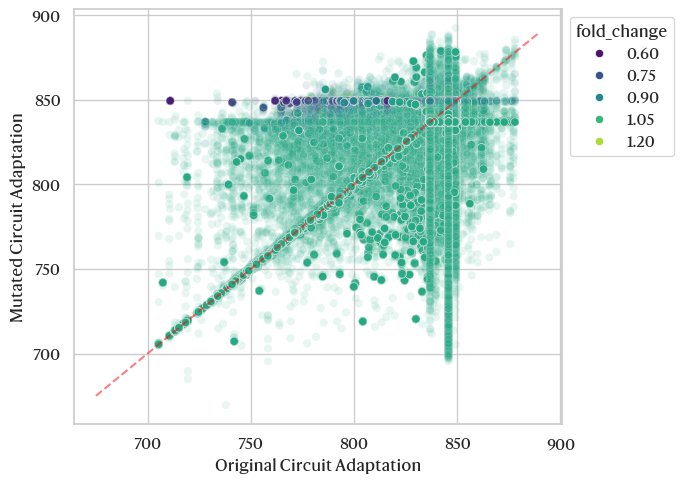

In [27]:
hue = 'overshoot'
hue = 'steady_states'
hue = 'initial_steady_states'
hue = 'fold_change'
k = 'adaptation'
k_text = k.capitalize().replace('Log', f'$Log_{{10}}$')
k_save = k.split(' ')[-1].lower()
xlim = [675, 890]
plt.figure(figsize=(7, 5))
sns.lineplot(x=xlim, y=xlim,
                color='red', linestyle='--', alpha=0.5)
g = sns.scatterplot(data[filt_samp & filt_m],
                    x=f'Original {k}', y=k,
                    hue=hue, palette=PALETTE, alpha=0.1, s=35)
for line in g.legend().get_lines():
    line.set_alpha(1)
sns.move_legend(g, "upper left", bbox_to_anchor=(
    1, 1), title=hue)
plt.ylabel(f'Mutated Circuit {k_text}')
plt.xlabel(f'Original Circuit {k_text}')
plt.tight_layout()
plt.savefig(os.path.join(top_write_dir, f'mutation_{k_save}_scatter_by_{hue}.png'),
            dpi=300, bbox_inches='tight', transparent=True)